# Why this notebook?
* Thanks to everyone who upvoted my previous notebook which is now gold medal status: https://www.kaggle.com/alexchwong/stop-guessing-conf-systematically-evaluate-f2
* The popularity of this and its cousin notebook by @locbaop: https://www.kaggle.com/locbaop/systematic-evaluate-f2-yolov5 suggest it is useful.
* The highest scoring public notebooks use yolov5 with Norfair tracking
* So is Norfair actually increasing F2 score, or is it just changing the F2/CONF curve?

# Why evaluate F2 score systematically?
* Each model is different in how the CONF parameter decides PRECISION and RECALL
* Finding which CONF level is often a matter of guesswork, and you are limited by 5 submissions per day.
* By systematically evaluating F2 score at each level of CONF, you can have a good idea which CONF will give you the best competition F2 metric.

* This assumes:
  * Your validation dataset is similar to the hidden test set
  * Your model has not seen your validation dataset

### Example model used in this notebook

* This notebook uses the YOLOX model kindly provided by @awsaf (https://www.kaggle.com/awsaf49/greatbarrierreef-yolov5-train-ds)
  * And assumes it is trained FOLD-4 as the model name implies
* Norfair tracking is implemented and code modified from @parapapapam (https://www.kaggle.com/parapapapam/yolox-inference-tracking-on-cots-lb-0-539)

### Warning
* Note the iteration time as an estimate to how long this notebook takes to run.
* Minimise wasting precious GPU minutes running at large resolutions. Test at small resolutions! The CONF peak should theoretically be the same.

In [105]:
import numpy as np

test_IOU = np.linspace(0.3, 0.8, 11)
test_IOU

array([        0.3,        0.35,         0.4,        0.45,         0.5,        0.55,         0.6,        0.65,         0.7,        0.75,         0.8])

### Which IOU should be used to evaluate histograms?
* NB the F2 scores are now calculated as the means at each tested IOU, for each level of confidence
* Histograms of TPs and FPs are only drawn for the given eval_IOU

In [106]:
eval_IOU = 0.4

# Control Panel (change your settings here)

In [107]:
# CONTROL PANEL (change your settings here instead)

# The path to your yolov5 model
MODEL_PATH = '../input/yolo1600fold10adam/best.pt'

#'../input/yolov5s6aug/best.pt'

#'../input/yolo-album-aug/best.pt'
#'../input/yolov5-weights-train-dim1280fold10/best.pt'
# '../input/yolo1600fold10adam/best.pt'
#'../input/dim2000fold10/best.pt'

# Confidence cutoff
INFER_CONF = 0.01

# Inference size
INFER_SIZE = 1280

# Whether to use yolov5 TTA
INFER_TTA = True

# Installation and Code

## Import Modules

In [108]:
import warnings
warnings.filterwarnings("ignore")

import os
import torch
import importlib
import cv2 
import pandas as pd
import numpy as np

import ast
import shutil
import sys

from tqdm.notebook import tqdm
tqdm.pandas()

from PIL import Image
from IPython.display import display

import copy # for deepcopy nested lists

## YOLOV5 Installation

In [109]:
!mkdir -p /root/.config/Ultralytics
!cp /kaggle/input/yolov5-font/Arial.ttf /root/.config/Ultralytics/

## Define the model here

In [110]:
model = torch.hub.load('../input/yolov5-lib-ds', 
                       'custom', 
                       path=MODEL_PATH,
                       source='local',
                       force_reload=True)  # local repo
model.conf = 0.01

YOLOv5 🚀 2022-2-5 torch 1.9.1 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients
Adding AutoShape... 


## IOU Calculation

In [111]:
def IOU_coco(bbox1, bbox2):
    '''
        adapted from https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation
    '''
    x_left = max(bbox1[0], bbox2[0])
    y_top = max(bbox1[1], bbox2[1])
    x_right = min(bbox1[0] + bbox1[2], bbox2[0] + bbox2[2])
    y_bottom = min(bbox1[1] + bbox1[3], bbox2[1] + bbox2[3])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = bbox1[2] * bbox1[3]
    bb2_area = bbox2[2] * bbox2[3]
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)

    assert iou >= 0.0
    assert iou <= 1.0
    return iou

## Visualization function

In [112]:
# Modified from https://www.kaggle.com/remekkinas/yolox-inference-on-kaggle-for-cots-lb-0-507

def draw_yolox_predictions(img, bboxes, scores, bbclasses, classes_dict, boxcolor = (0,0,255)):
    outimg = img.copy()
    for i in range(len(bboxes)):
        box = bboxes[i]
        cls_id = int(bbclasses[i])
        score = scores[i]
        x0 = int(box[0])
        y0 = int(box[1])
        x1 = x0 + int(box[2])
        y1 = y0 + int(box[3])

        cv2.rectangle(outimg, (x0, y0), (x1, y1), boxcolor, 2)
        cv2.putText(outimg, '{}:{:.1f}%'.format(classes_dict[cls_id], score * 100), (x0, y0 - 3), cv2.FONT_HERSHEY_PLAIN, 0.8, boxcolor, thickness = 1)
    return outimg

COCO_CLASSES = ("starfish")

## Norfair

### Installation

In [113]:
# norfair dependencies
%cd /kaggle/input/norfair031py3/
!pip install commonmark-0.9.1-py2.py3-none-any.whl -f ./ --no-index
!pip install rich-9.13.0-py3-none-any.whl

!mkdir /kaggle/working/tmp
!cp -r /kaggle/input/norfair031py3/filterpy-1.4.5/filterpy-1.4.5/ /kaggle/working/tmp/
%cd /kaggle/working/tmp/filterpy-1.4.5/
!pip install .
!rm -rf /kaggle/working/tmp

# norfair
%cd /kaggle/input/norfair031py3/
!pip install norfair-0.3.1-py3-none-any.whl -f ./ --no-index

/kaggle/input/norfair031py3
Looking in links: ./
Processing ./commonmark-0.9.1-py2.py3-none-any.whl
commonmark is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Processing ./rich-9.13.0-py3-none-any.whl
rich is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
/kaggle/working/tmp/filterpy-1.4.5
Processing /kaggle/working/tmp/filterpy-1.4.5
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110474 sha256=da3885043e37303c65b47

### Functions

In [114]:
from norfair import Detection, Tracker

# Helper to convert bbox in format [x_min, y_min, w, h] and scores to norfair.Detection class
def to_norfair(bboxes, scores, frame_id):
    result = []
    for bb, score in zip(bboxes, scores):
        xc, yc = bb[0] + int(round(bb[2] / 2.0)), bb[1] + int(round(bb[3] / 2.0))
        w, h = bb[2], bb[3]
        result.append(Detection(points=np.array([xc, yc]), scores=np.array([score]), data=np.array([w, h, frame_id])))
        
    return result

# Euclidean distance function to match detections on this frame with tracked_objects from previous frames
def euclidean_distance(detection, tracked_object):
    return np.linalg.norm(detection.points - tracked_object.estimate)

### Tracker list initialization

In [115]:
tracker = Tracker(
    distance_function=euclidean_distance, 
    distance_threshold=30,
    hit_inertia_min=3,
    hit_inertia_max=6,
    initialization_delay=1,
)

### Function to parse YOLOV5 output to tracker

In [116]:
def norfair_track(tracker, frame_id, bboxes, bbclasses, scores):
    """
        inputs:
        * tracker: the tracker object to process
        * bboxes, bbclasses, scores: processed model output
    """
    bboxes_out = []
    bbclasses_out = []
    scores_out = []
    
    if len(bboxes):
        bboxes_out = copy.deepcopy(bboxes)
        bbclasses_out = copy.deepcopy(bbclasses)
        scores_out = copy.deepcopy(scores)
    
    tracked_objects = tracker.update(detections=to_norfair(bboxes, scores, frame_id))
    
    for tobj in tracked_objects:
        bbox_width, bbox_height, last_detected_frame_id = tobj.last_detection.data
        if last_detected_frame_id == frame_id:  # Skip objects that were detected on current frame
            continue
        
        # print("Adding new bbox")
        # Add objects that have no detections on current frame to predictions
        xc, yc = tobj.estimate[0]
        x_min, y_min = int(round(xc - bbox_width / 2)), int(round(yc - bbox_height / 2))
        score = tobj.last_detection.scores[0]
        
        bboxes_out.append([x_min, y_min, bbox_width, bbox_height])
        bbclasses_out.append(0)
        scores_out.append(score)
    
    return bboxes_out, bbclasses_out, scores_out

# Retrieve video frames not used in training

In [117]:
%cd /kaggle/working

from sklearn.model_selection import GroupKFold

def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

def get_path(row):
    row['image_path'] = f'{ROOT_DIR}/train_images/video_{row.video_id}/{row.video_frame}.jpg'
    return row

ROOT_DIR  = '/kaggle/input/tensorflow-great-barrier-reef/'

df = pd.read_csv("../input/reef-cv-strategy-subsequences-dataframes/cross-validation/train-10folds.csv")

# Don't filter for annotated frames. Include frames with no bboxes as well!
df["num_bbox"] = df['annotations'].apply(lambda x: str.count(x, 'x'))
df_train = df

# Annotations 
df_train['annotations'] = df_train['annotations'].progress_apply(lambda x: ast.literal_eval(x))
df_train['bboxes'] = df_train.annotations.progress_apply(get_bbox)

df_train = df_train.progress_apply(get_path, axis=1)

# kf = GroupKFold(n_splits = 10) 
# df_train = df_train.reset_index(drop=True)
# df_train['fold'] = -1
# for fold, (train_idx, val_idx) in enumerate(kf.split(df_train, y = df_train.video_id.tolist(), groups=df_train.sequence)):
#     df_train.loc[val_idx, 'fold'] = fold

df_train.head(5)

/kaggle/working


  0%|          | 0/23501 [00:00<?, ?it/s]

  0%|          | 0/23501 [00:00<?, ?it/s]

  0%|          | 0/23501 [00:00<?, ?it/s]

,video_id,sequence,video_frame,sequence_frame,image_id,...,image_path,subsequence_id,fold,num_bbox,bboxes
0,0,40258,0,0,0-0,...,/kaggle/input/tensorflow-great-barrier-reef//t...,1,5,0,[]
1,0,40258,1,1,0-1,...,/kaggle/input/tensorflow-great-barrier-reef//t...,1,5,0,[]
2,0,40258,2,2,0-2,...,/kaggle/input/tensorflow-great-barrier-reef//t...,1,5,0,[]
3,0,40258,3,3,0-3,...,/kaggle/input/tensorflow-great-barrier-reef//t...,1,5,0,[]
4,0,40258,4,4,0-4,...,/kaggle/input/tensorflow-great-barrier-reef//t...,1,5,0,[]


### Select the dataset that your model hasn't seen!

In [118]:
df_test = df_train[df_train.fold == 1]

### Get image paths and ground truth BB's

In [119]:
# deepcopy is required to avoid contaminating input data

df_sample = df_test
image_paths = df_sample.image_path.tolist()
gt = copy.deepcopy(df_sample.bboxes.tolist())
gtmem = copy.deepcopy(df_sample.bboxes.tolist())

# Test your model is working

In [120]:
def yolov5_infer(model, img, size, augment):
    r = model(img, size=size, augment=augment)
    
    bboxes = []
    bbclasses = []
    scores = []
    if r.pandas().xyxy[0].shape[0] > 0:
        res = np.array(r.pandas().xyxy[0])
        for r in res:
            # Filter by INFER_CONF
            if r[4] > INFER_CONF:
                bb = r[0:4]
                bb[2:4] -= bb[0:2] # Convert to xywh format
                bboxes.append(bb.tolist()) # output bboxes as a nested list instead of numpy array
                scores.append(r[4])
                bbclasses.append(r[5])
    
    return bboxes, bbclasses, scores

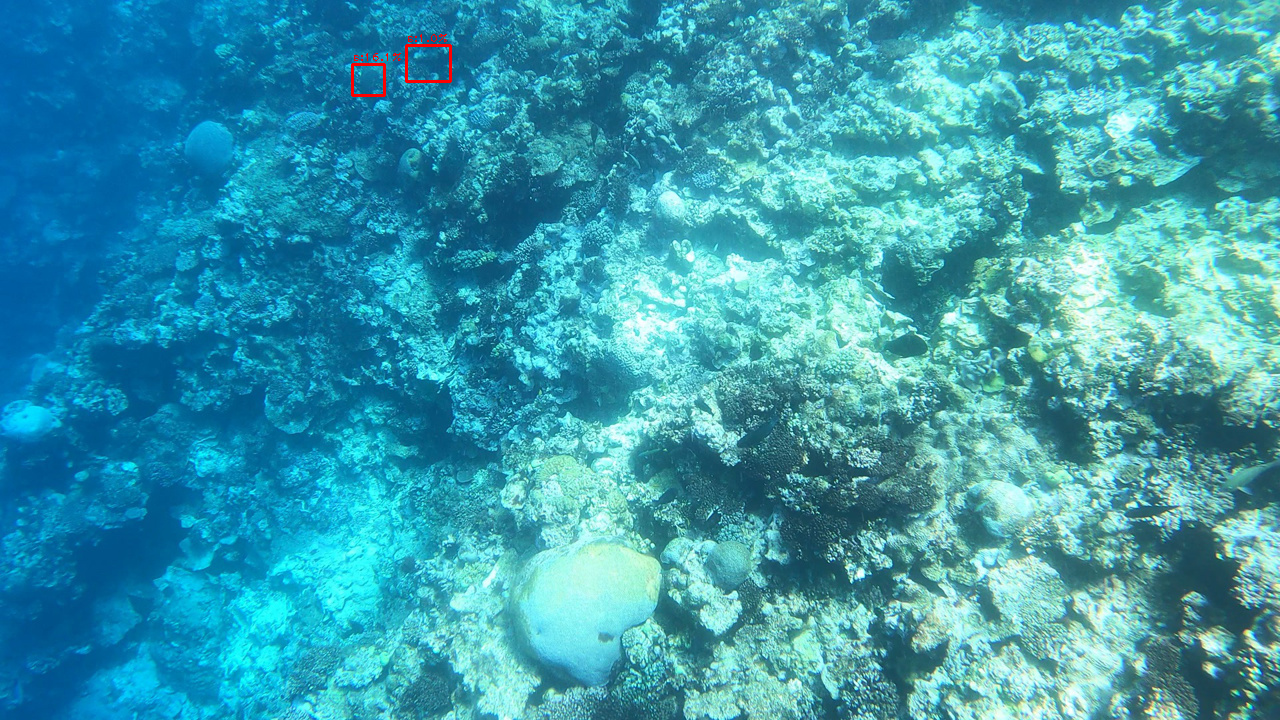

In [121]:
i = 1400
TEST_IMAGE_PATH = image_paths[i]
img = cv2.imread(TEST_IMAGE_PATH)

# Insert your inference code here:
bboxes, bbclasses, scores = yolov5_infer(model, img, INFER_SIZE, INFER_TTA)

# Draw Green ground truth box
out_image = draw_yolox_predictions(img, gt[i], [1.0] * len(gt[i]), [0] * len(gt[i]), COCO_CLASSES, (0,255,0))

# Draw Red inference box
out_image = draw_yolox_predictions(out_image, bboxes, scores, bbclasses, COCO_CLASSES, (0,0,255))

# Convert BGR to RGB
out_image = cv2.cvtColor(out_image, cv2.COLOR_BGR2RGB)

display(Image.fromarray(out_image))

# Assess Model Performance

In [122]:
def calc_pos_and_negs(bboxes, scores, gt_bboxes, IOU):
    TP = []
    FP = []
    FN = 0
    
    gt0 = copy.deepcopy(gt_bboxes)
    bb = copy.deepcopy(bboxes)
    
    if len(bboxes) == 0:
        # all gt are false negative
        FN += len(gt0)
    else:
        for idx, b in enumerate(bb):
            b.append(scores[idx])
        bb.sort(key = lambda x: x[4], reverse = True)

        if len(gt0) == 0:
            # all bboxes are false positives
            for b in bb:
                FP.append(b[4])
        else:
            # match bbox with gt
            for b in bb:
                matched = False
                for g in gt0:
                    # check whether gt box is already matched to an inference bb
                    if len(g) == 4:
                        # g bbox is unmatched
                        if IOU_coco(b, g) >= IOU:
                            g.append(b[4]) # assign confidence values to g; marks g as matched
                            matched = True
                            TP.append(b[4])
                            break
                if not matched:
                    FP.append(b[4])
            for g in gt0:
                if len(g) == 4:
                    FN += 1
    return TP, FP, FN

In [123]:
%cd /kaggle/working

# Confidence scores of true positives, false positives and count false negatives

# Yolov5
TP_base = [[] for r in test_IOU] # Confidence scores of true positives
FP_base = [[] for r in test_IOU] # Confidence scores of true positives
FN_base = [0 for r in test_IOU]  # Count of false negative boxes

# Norfair
TP_nf = [[] for r in test_IOU] # Confidence scores of true positives
FP_nf = [[] for r in test_IOU] # Confidence scores of true positives
FN_nf = [0 for r in test_IOU]  # Count of false negative boxes

fid = 0

for i in tqdm(range(len(image_paths))):
# for i in tqdm(range(1250, 1450)):
    TEST_IMAGE_PATH = image_paths[i]
    img = cv2.imread(TEST_IMAGE_PATH)
    
    # Base yolov5
    bboxes, bbclasses, scores = yolov5_infer(model, img, INFER_SIZE, INFER_TTA)

    # Base norfair
    bboxes_track, bbclasses_track, scores_track = norfair_track(tracker, fid, bboxes, bbclasses, scores)
    
    # Increment frame ID
    fid += 1
    
    # yolov5 evaluation
    for idx, IOU in enumerate(test_IOU):
        TP, FP, FN = calc_pos_and_negs(bboxes, scores, gt[i], IOU)
        if len(TP):
            TP_base[idx].append(TP)
        if len(FP):
            FP_base[idx].append(FP)
        FN_base[idx] += FN

        # yolov5 norfair evaluation
        TP, FP, FN = calc_pos_and_negs(bboxes_track, scores_track, gt[i], IOU)
        if len(TP):
            TP_nf[idx].append(TP)
        if len(FP):
            FP_nf[idx].append(FP)
        FN_nf[idx] += FN

/kaggle/working


  0%|          | 0/1987 [00:00<?, ?it/s]

In [124]:
# Flatten nested lists

for idx, IOU in enumerate(test_IOU):
    TP_base[idx] = [item for sublist in TP_base[idx] for item in sublist]
    FP_base[idx] = [item for sublist in FP_base[idx] for item in sublist]
    TP_nf[idx] = [item for sublist in TP_nf[idx] for item in sublist]
    FP_nf[idx] = [item for sublist in FP_nf[idx] for item in sublist]

In [125]:
for idx, IOU in enumerate(test_IOU):
    print(IOU, len(TP_base[idx]), len(FP_base[idx]), FN_base[idx])

0.3 185 8309 518
0.35 185 8309 518
0.4 183 8311 520
0.45 175 8319 528
0.5 168 8326 535
0.55 156 8338 547
0.6000000000000001 135 8359 568
0.65 115 8379 588
0.7 97 8397 606
0.75 76 8418 627
0.8 38 8456 665


# Display your model's Metrics

In [126]:
# Which IOU to evaluate in histograms
eval_IOU_idx = np.where(np.isclose(test_IOU,eval_IOU))
eval_IOU_idx = eval_IOU_idx[0][0]

### Base YOLOV5

In [127]:
from matplotlib import pyplot as plt
%matplotlib inline

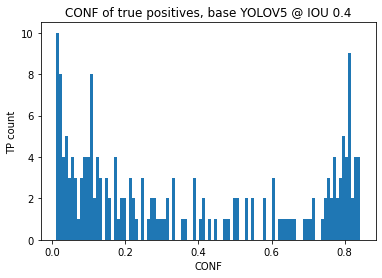

True positives = 183
False negatives = 520


In [128]:
plt.hist(TP_base[eval_IOU_idx], 100)
plt.title(f"CONF of true positives, base YOLOV5 @ IOU {eval_IOU}")
plt.xlabel('CONF')
plt.ylabel('TP count')
plt.show()

print(f'True positives = {len(TP_base[eval_IOU_idx])}')
print(f'False negatives = {FN_base[eval_IOU_idx]}')

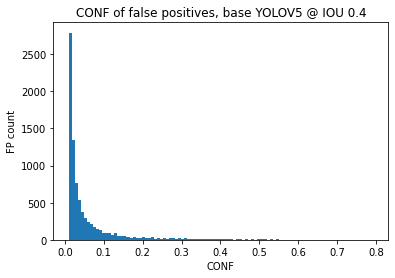

False positives = 8311


In [129]:
plt.hist(FP_base[eval_IOU_idx], 100)
plt.title(f"CONF of false positives, base YOLOV5 @ IOU {eval_IOU}")
plt.xlabel('CONF')
plt.ylabel('FP count')
plt.show()

print(f'False positives = {len(FP_base[eval_IOU_idx])}')

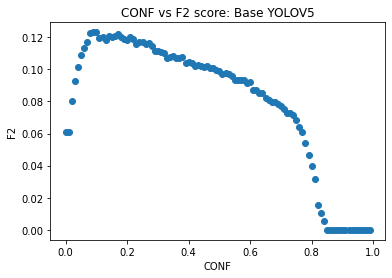

F2 max is 0.12303834302377635 at CONF = 0.09


In [130]:
from statistics import mean

F2list = []
F2max = 0.0
F2maxat = -1.0
F2mean = 0.0

for c in np.arange(0.0, 1.0, 0.01):
    F2temp = []
    
    for idx, IOU in enumerate(test_IOU):
        FNcount = FN_base[idx] + sum(1 for i in TP_base[idx] if i < c)
        TPcount = sum(1 for i in TP_base[idx] if i >= c)
        FPcount = sum(1 for i in FP_base[idx] if i >= c)
        R = TPcount / (TPcount + FNcount + 0.0001)
        P = TPcount / (TPcount + FPcount + 0.0001)
        F2 = (5 * P * R) / (4 * P + R + 0.0001)
        F2temp.append(F2)
    
    F2mean = mean(F2temp)
    F2list.append((c, F2mean))
    if F2max < F2mean:
        F2max = F2mean
        F2maxat = c

plt.scatter(*zip(*F2list))
plt.title("CONF vs F2 score: Base YOLOV5")
plt.xlabel('CONF')
plt.ylabel('F2')
plt.show()

print(f'F2 max is {F2max} at CONF = {F2maxat}')

### YOLOV5 Norfair

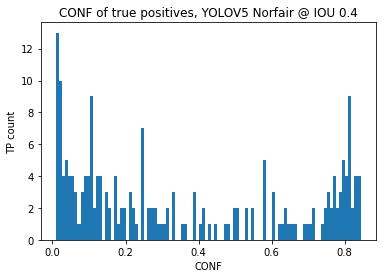

True positives = 200
False negatives = 503


In [131]:
plt.hist(TP_nf[eval_IOU_idx], 100)
plt.title(f"CONF of true positives, YOLOV5 Norfair @ IOU {eval_IOU}")
plt.xlabel('CONF')
plt.ylabel('TP count')
plt.show()

print(f'True positives = {len(TP_nf[eval_IOU_idx])}')
print(f'False negatives = {FN_nf[eval_IOU_idx]}')

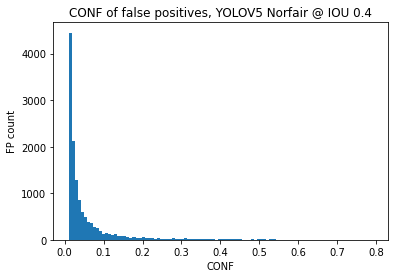

False positives = 13167


In [132]:
plt.hist(FP_nf[eval_IOU_idx], 100)
plt.title(f"CONF of false positives, YOLOV5 Norfair @ IOU {eval_IOU}")
plt.xlabel('CONF')
plt.ylabel('FP count')
plt.show()

print(f'False positives = {len(FP_nf[eval_IOU_idx])}')

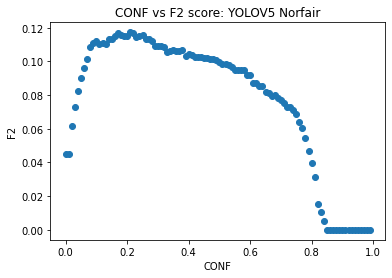

F2 max is 0.11728437098617221 at CONF = 0.21


In [133]:
F2list = []
F2max = 0.0
F2maxat = -1.0
F2mean = 0.0

for c in np.arange(0.0, 1.0, 0.01):
    F2temp = []
    
    for idx, IOU in enumerate(test_IOU):
        FNcount = FN_nf[idx] + sum(1 for i in TP_nf[idx] if i < c)
        TPcount = sum(1 for i in TP_nf[idx] if i >= c)
        FPcount = sum(1 for i in FP_nf[idx] if i >= c)
        R = TPcount / (TPcount + FNcount + 0.0001)
        P = TPcount / (TPcount + FPcount + 0.0001)
        F2 = (5 * P * R) / (4 * P + R + 0.0001)
        F2temp.append(F2)
    
    F2mean = mean(F2temp)
    F2list.append((c, F2mean))
    if F2max < F2mean:
        F2max = F2mean
        F2maxat = c

plt.scatter(*zip(*F2list))
plt.title("CONF vs F2 score: YOLOV5 Norfair")
plt.xlabel('CONF')
plt.ylabel('F2')
plt.show()

print(f'F2 max is {F2max} at CONF = {F2maxat}')

### Cleanup

In [134]:
!rm -rf /kaggle/working/*